**João Castanheira 55052 | Gustavo Fonseca 55054**

# Data Mining / Prospecção de Dados

## Sara C. Madeira and André Falcão, 2019/20

# Project 1 - Pattern Mining

## Dataset and Tools

For this project we decided to test both an Apriori and an FPGrowth algorithm in the first exercise for the purpose of Pattern Mining. In accordance with the first Project for Data Mining course in FCUL, we analysed a dataset named **`Foodmart_2020_PD.csv`**.

This dataset stores **69549 transactions** from **24 stores**, where **103 different products** can be bought. Each transaction (row) has a STORE_ID (integer from 1 to 24), and a list of products (items), together with the quantities bought. In the transation highlighted below, a customer bought 1 unit of soup, 2 of cheese and 1 of wine at store 2.

<img src="Foodmart_2020_PD_Example.png" alt="Foodmart_2020_PD_Example" style="width: 1000px;"/>

## 0. Imports

In [1]:
import pandas as pd
import numpy as np
from mlxtend.preprocessing import TransactionEncoder
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori, fpgrowth
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import fpmax

## 1. Mining Frequent Itemsets and Association Rules: Ignoring Product Quantities and Stores

In this first part of the project you should load and preprocessed the dataset **`Foodmart_2020_PD.csv`** in order to compute frequent itemsets and generate association rules considering all the transactions, regardeless of the store, and ignoring product quantities.

### 1.1. Load and Preprocess Dataset

 **Product quantities and stores should not be considered.**

Load the data

In [2]:
df_itemset = pd.read_csv('./data/Foodmart_2020_PD.csv', delimiter = ';')
df_itemset.shape

(69549, 11)

Our dataset consists of 69549 transactions.

The Dataframe have 11 columns, which means that the transaction with most products has 11 products.

In [3]:
df_itemset.head()

,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8,Column9,Column10,Column11
0,STORE_ID=2,Pasta=3,Soup=2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,STORE_ID=2,Soup=1,Fresh Vegetables=3,Milk=3,Plastic Utensils=2,NaN,NaN,NaN,NaN,NaN,NaN
2,STORE_ID=2,Cheese=2,Deodorizers=1,Hard Candy=2,Jam=2,NaN,NaN,NaN,NaN,NaN,NaN
3,STORE_ID=2,Fresh Vegetables=2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,STORE_ID=2,Cleaners=1,Cookies=2,Eggs=2,Preserves=1,NaN,NaN,NaN,NaN,NaN,NaN


**Preprocessing**

In this section, preprocessing will be done in order to remove the store column and the quantities from the dataset.

In [4]:
def clear_quantities(x):
    if isinstance(x,str):
        item = x.split('=')
        return item[0]
    else:
        return x
    
def remove_nan(transactions):
    #remove nan values
    transactions_cleaned = []
    for i, t in enumerate(transactions):
        transaction = []
        for v in t: 
            if isinstance(v,str): transaction.append(v)
        transactions_cleaned.append(transaction)
    return transactions_cleaned

Remove store column from dataset and clear quantities.

In [5]:
#remove store column
df1 = df_itemset.loc[:,'Column2':'Column11']

#clear quantities
df1 = df1.applymap(clear_quantities)

In [6]:
df1.head()

,Column2,Column3,Column4,Column5,Column6,Column7,Column8,Column9,Column10,Column11
0,Pasta,Soup,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Soup,Fresh Vegetables,Milk,Plastic Utensils,NaN,NaN,NaN,NaN,NaN,NaN
2,Cheese,Deodorizers,Hard Candy,Jam,NaN,NaN,NaN,NaN,NaN,NaN
3,Fresh Vegetables,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Cleaners,Cookies,Eggs,Preserves,NaN,NaN,NaN,NaN,NaN,NaN


After removing quantities and store column, we get the DataFrame above.

Now lets convert the Dataframe to a matrix and remove the 'NaN' values in each vector (transaction), before fed the matrix into the Transaction Encoder.

In [7]:
transactions_cleaned = remove_nan(df1.values)

# View just the first 5 transactions
transactions_cleaned[:5]

[['Pasta', 'Soup'],
 ['Soup', 'Fresh Vegetables', 'Milk', 'Plastic Utensils'],
 ['Cheese', 'Deodorizers', 'Hard Candy', 'Jam'],
 ['Fresh Vegetables'],
 ['Cleaners', 'Cookies', 'Eggs', 'Preserves']]

Now lets apply the Transaction Encoder, it transforms our data into the input format of FP-Growth and Apriori algorithms.

In [8]:
te = TransactionEncoder()
te_ary = te.fit(transactions_cleaned).transform(transactions_cleaned)
df_te = pd.DataFrame(te_ary, columns=te.columns_)
df_te.head()

,Acetominifen,Anchovies,Aspirin,Auto Magazines,Bagels,Batteries,Beer,Bologna,Candles,Canned Fruit,...,Sunglasses,TV Dinner,Tofu,Toilet Brushes,Tools,Toothbrushes,Tuna,Waffles,Wine,Yogurt
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


The transaction encoder dataframe has the following structure:

* Each row represents one transaction;
* Each column represents a product, and it is boolean: assumes True if the transaction contains that product, and False otherwise.

The dataframe outputed by the transaction has 102 columns, which means that our dataset has 102 unique products in all transactions.

**Small exploratory data analysis**

Lets explore the products that we have in the dataset

In [9]:
df_products_frequency = pd.DataFrame()
for c in df_te.columns:
    df_c = df_te[c].value_counts().to_frame('count')
    total = int(df_c[df_c.index == True]['count']) # Count True values
    df_products_frequency = df_products_frequency.append({'product':c,'total': total,'support':(total/len(df_itemset))},ignore_index = True)
df_products_frequency = df_products_frequency.sort_values('total',ascending = False).reset_index(drop=True)

# Making it more presentable
df_products_frequency['support'] = df_products_frequency['support'].astype('float64').round(3)
df_products_frequency['total'] = df_products_frequency['total'].astype('int64')

df_products_frequency.head()

,product,support,total
0,Fresh Vegetables,0.284,19764
1,Fresh Fruit,0.175,12187
2,Soup,0.120,8350
3,Cheese,0.118,8193
4,Dried Fruit,0.117,8152


The most bought products are Fresh Vegatable, Fresh Fruit, Soup, Cheese and Dried Fruit.

Fresh Vegatable has a support of 0.284, which means that 28% of the transactions (19764 transactions) include this product.

Compute some statistic metrics about the total column

In [10]:
df_products_frequency.total.describe()

count      102.000000
mean      2834.500000
std       2589.666372
min        895.000000
25%        971.000000
50%       1991.000000
75%       3747.500000
max      19764.000000
Name: total, dtype: float64

We can see that on average each product appears in 2834 transactions (+/- 2589.67 std). The less purchased product appears in 895 transactions, and the most bought product appears in 19764 transactions.

We know that the most bought product is Fresh Vegatable, now lets check the less purchased product.

In [11]:
df_products_frequency.iloc[df_products_frequency['total'].values.argmin()]

product    Fresh Fish
support         0.013
total             895
Name: 101, dtype: object

The less purchased product is Fresh Fish, which appears in just 895 transactions, just 1.3% of the transactions in the dataset.

Now lets plot the 20 most frequent bought products

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 <a list of 20 Text xticklabel objects>)

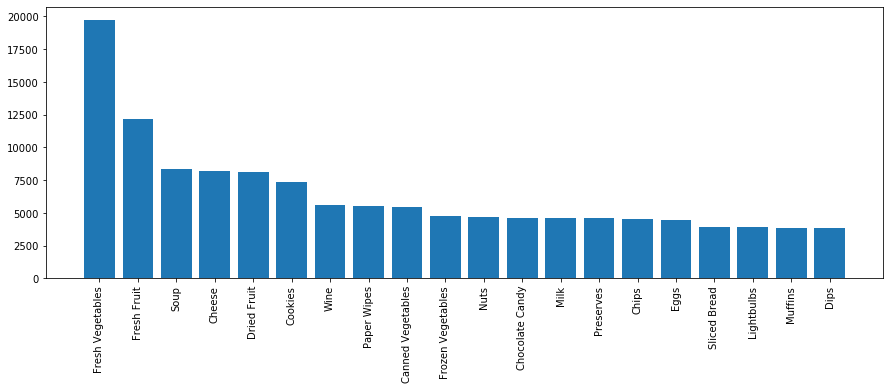

In [12]:
plt.figure(figsize=(15,5))
df_graph = df_products_frequency.iloc[:20]
plt.bar(df_graph['product'],df_graph['total'])
plt.xticks(rotation=90)

The figure above shows that Fresh Vegetables is by far the most purchased product.

### 1.2. Compute Frequent Itemsets

* Compute frequent itemsets considering a minimum support of X%. 
* Present frequent itemsets organized by length (number of items). 
* List frequent 1-itemsets, 2-itemsets, 3-itemsets, etc with support of at least Y%.
* Change X and Y when it makes sense and discuss the results.

Now lets use Apriori and FP Growth to compute frequent itemsets, compare their performances, and use that itemsets to compute association rules.

In [13]:
X = 0.005
Y = 0.007

### 1.2.1 Using apriori algorithm

In [14]:
%timeit apriori(df_te, min_support=X, use_colnames=True)

11.3 s ± 2.41 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


The apriori algorithm takes +- 10 seconds per loop with min_support = 0.005

Now lets compute the frequent itemsets of length 1, 2 and 3. We will create a column named 'num_transactions' which indicates approximately the number of transactions were that item set occurs.

In [15]:
frequent_itemsets  = apriori(df_te, min_support=X, use_colnames=True)
frequent_itemsets = frequent_itemsets.sort_values('support',ascending = False)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets['num_transactions'] = [round(s*len(df_itemset)) for s in frequent_itemsets['support']]
frequent_itemsets = frequent_itemsets.sort_values('support',ascending = False)

In [16]:
frequent_itemsets.query(f'length == 1 & support > {Y}')

,support,itemsets,length,num_transactions
40,0.284174,(Fresh Vegetables),1,19764
39,0.175229,(Fresh Fruit),1,12187
86,0.120059,(Soup),1,8350
12,0.117802,(Cheese),1,8193
31,0.117212,(Dried Fruit),1,8152
...,...,...,...,...
3,0.013343,(Auto Magazines),1,928
79,0.013271,(Sauces),1,923
34,0.013156,(Fashion Magazines),1,915
62,0.012998,(Pancakes),1,904


In [17]:
frequent_itemsets.query(f'length == 2 & support > {Y}')

,support,itemsets,length,num_transactions
268,0.050914,"(Fresh Vegetables, Fresh Fruit)",2,3541
332,0.035443,"(Fresh Vegetables, Soup)",2,2465
235,0.035227,"(Fresh Vegetables, Dried Fruit)",2,2450
146,0.031144,"(Fresh Vegetables, Cheese)",2,2166
195,0.027721,"(Fresh Vegetables, Cookies)",2,1928
...,...,...,...,...
200,0.007031,"(Milk, Cookies)",2,489
112,0.007031,"(Fresh Fruit, Bologna)",2,489
167,0.007017,"(Wine, Cheese)",2,488
297,0.007002,"(Fresh Fruit, Spices)",2,487


Fresh Vegetables and Fresh Fruit are bought together in 3541 transactions, which represents 5.1% of the total.

With a minimum support of 0.7%, we get 159 itemsets of size 2.

In [18]:
frequent_itemsets.query(f'length == 3 & support > {Y}')

,support,itemsets,length,num_transactions
372,0.007045,"(Fresh Vegetables, Fresh Fruit, Soup)",3,490


In [19]:
frequent_itemsets.query(f'length == 4 & support > {Y}')

,support,itemsets,length,num_transactions


With a support > 0.007 there is no frequent itemset with 4 products, and just one itemset with 3 products (Fresh Vegetables, Soup and Fresh Fruit).

### 1.2.2 Using FP-Growth

According to [1], the apriori algorithm suffers from two main performance issues:

* It may still need to generate a huge number of candidate sets. For example, if there are
104 frequent 1-itemsets, the Apriori algorithm will need to generate more than 107
candidate 2-itemsets.

* It may need to repeatedly scan the whole database and check a large set of candidates by
pattern matching. It is costly to go over each transaction in the database to determine
the support of the candidate itemsets.

Frequent pattern growth, or simply FP-Growth, is a method that mines the complete set of frequent itemsets without such a costly candidate generation process [1].

Now lets compute the frequent itemsets by using FP-Growth algorithm.

In [20]:
%timeit fpgrowth(df_te, min_support=X, use_colnames=True)

1.5 s ± 41.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
frequent_itemsets_fpg  = fpgrowth(df_te, min_support=X, use_colnames=True)
frequent_itemsets_fpg = frequent_itemsets_fpg.sort_values('support',ascending = False)
frequent_itemsets_fpg['length'] = frequent_itemsets_fpg['itemsets'].apply(lambda x: len(x))
frequent_itemsets_fpg['num_transactions'] = [round(s*len(df_itemset)) for s in frequent_itemsets_fpg['support']]
frequent_itemsets_fpg = frequent_itemsets_fpg.sort_values('support',ascending = False)

In [22]:
frequent_itemsets_fpg.query(f'length == 1 & support > {Y}')

,support,itemsets,length,num_transactions
2,0.284174,(Fresh Vegetables),1,19764
29,0.175229,(Fresh Fruit),1,12187
0,0.120059,(Soup),1,8350
5,0.117802,(Cheese),1,8193
32,0.117212,(Dried Fruit),1,8152
...,...,...,...,...
100,0.013343,(Sardines),1,928
34,0.013271,(Sauces),1,923
83,0.013156,(Fashion Magazines),1,915
95,0.012998,(Pancakes),1,904


In [23]:
frequent_itemsets_fpg.query(f'length == 2 & support > {Y}')

,support,itemsets,length,num_transactions
211,0.050914,"(Fresh Vegetables, Fresh Fruit)",2,3541
102,0.035443,"(Fresh Vegetables, Soup)",2,2465
223,0.035227,"(Fresh Vegetables, Dried Fruit)",2,2450
122,0.031144,"(Fresh Vegetables, Cheese)",2,2166
129,0.027721,"(Fresh Vegetables, Cookies)",2,1928
...,...,...,...,...
113,0.007031,"(Milk, Cookies)",2,489
207,0.007031,"(Fresh Fruit, Bologna)",2,489
358,0.007017,"(Wine, Cheese)",2,488
261,0.007002,"(Soda, Dried Fruit)",2,487


In [24]:
frequent_itemsets_fpg.query(f'length == 3 & support > {Y}')

,support,itemsets,length,num_transactions
104,0.007045,"(Fresh Vegetables, Fresh Fruit, Soup)",3,490


Considering that FP Growth is using a highly compact FP-tree, divide-and-conquer method, it is much faster than Apriori. We can observe this by the 10x increase in speed. Both results are the same. During the next exercises we will use just FP Growth.

About the results, they translate the frequency of a certain set of items being bought, and the higher the length of the set, the lower generally is the support. We can see this by having only one example for a length of 3 and more than 100 examples for length of 1 and 2. With a minimum support of 0.007 we have 102 frequent itemsets with one product, 159 frequent itemsets with two products and just one frequent itemset of size 3. If Y > 0.007045 there will be no itemsets of size 3.

Now lets increase Y and check them most frequent itemsets of size 1 and 2.

In [25]:
Y = 0.025

In [26]:
frequent_itemsets_fpg.query(f'length == 1 & support > {Y}')

,support,itemsets,length,num_transactions
2,0.284174,(Fresh Vegetables),1,19764
29,0.175229,(Fresh Fruit),1,12187
0,0.120059,(Soup),1,8350
5,0.117802,(Cheese),1,8193
32,0.117212,(Dried Fruit),1,8152
...,...,...,...,...
79,0.027132,(Crackers),1,1887
62,0.026715,(Sour Cream),1,1858
77,0.026657,(Aspirin),1,1854
56,0.026586,(Tools),1,1849


In [27]:
frequent_itemsets_fpg.query(f'length == 2 & support > {Y}')

,support,itemsets,length,num_transactions
211,0.050914,"(Fresh Vegetables, Fresh Fruit)",2,3541
102,0.035443,"(Fresh Vegetables, Soup)",2,2465
223,0.035227,"(Fresh Vegetables, Dried Fruit)",2,2450
122,0.031144,"(Fresh Vegetables, Cheese)",2,2166
129,0.027721,"(Fresh Vegetables, Cookies)",2,1928


If we increase Y we are minimizing our tolerance, and so, getting just the frequent itemsets that are more frequent according to the Y threshold.

With Y = 0.05, we get 67 frequent itemsets of size 1 and 5 of size 2. 

Fresh Vegetables and Fresh Fruit were bought together 3541 times, and Fresh Vegetables and Cookies were bought together 1928 times. It is interesting to note that in all frequents itemsets of length 2 that we got, Fresh Vegetables is always one of the items. This happens because Fresh Vegetables are the most frequent product in the dataset.

An interesting thing to  note is that if we have a very low Y, we end up with more itemsets of length 2 than others, due to the large possible combinations we can have, but these tend to have a lower support so the higher the support, the higher the percentage of smaller length itemsets, and vice versa.

### 1.3. Generate Association Rules from Frequent Itemsets

* Generate association rules with a minimum confidence of C%. 
* Generate association rules with a minimum lift L. 
* Generate association rules with both confidence >= C% and lift >= L.
* Change C and L when it makes sense and discuss the results.

Lets start by define a confidence level of 30% and 1.1 of Lift.

In [28]:
C = 0.3 # Confidence
L = 1.1 # Lift

In [29]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0)
rules['antecedent_len'] = rules['antecedents'].apply(lambda x: len(x))

In [30]:
def generate_fi(rules, length, C, L):
    return rules[ (rules['antecedent_len'] >= length) &
         (rules['confidence'] >= C) &
         (rules['lift'] > L)]

In [31]:
association_rules_1 = generate_fi(rules, 1, C, L)
association_rules_1 = association_rules_1.sort_values('confidence',ascending = False)
association_rules_1.shape

(3, 10)

In [32]:
association_rules_1

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
310,"(Fresh Fruit, Soup)",(Fresh Vegetables),0.020748,0.284174,0.007045,0.339570,1.194939,0.001149,1.083880,2
183,(Aspirin),(Fresh Vegetables),0.026657,0.284174,0.008598,0.322546,1.135030,0.001023,1.056642,1
171,(Hamburger),(Fresh Vegetables),0.028297,0.284174,0.008943,0.316057,1.112196,0.000902,1.046617,1


We can consider that anything with a confidence below 0.5 is 'not so confident' but a lift over 1 makes it likely to happen. Lift is a correlation metric.

> When lift is less than 1, then the occurrence of A is negatively correlated with the occurrence of B, meaning that the occurrence of one likely leads to the absence of the other one. If the resulting value is greater than 1, then A and B are positively correlated, meaning that the occurrence of one implies the occurrence of the other. If the resulting value is equal to 1, then A and B are independent and there is no
correlation between them [1].

Therefore the top 3 rules found for this frequent itemsets are the following:

+ If someone buys an Hamburguer, they buy Fresh Vegetables with a confidence of +- 0.32;
+ If someone buys Aspirin, they buy Fresh Vegetables with a confidence of 0.32;
+ If someone buys Soup and Fresh Fruit, they buy Fresh Vegetables. This is the association rule with the highest confidence: 0.33 and lift.

In all of that top 3 rules found, lift is higher than 1, meaning that the products are positive related between them.

Now lets decrease the confidence to 0.2 and increase the lift to 1.2

In [33]:
C = 0.2 # Confidence
L = 1.2 # Lift

In [34]:
association_rules_2 = generate_fi(rules, 1, C, L)
association_rules_2 = association_rules_2.sort_values('confidence',ascending = False)
association_rules_2.shape

(2, 10)

In [35]:
association_rules_2

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
337,(Rice),(Fresh Fruit),0.031891,0.175229,0.006844,0.214608,1.224728,0.001256,1.050139,1
175,(TV Dinner),(Fresh Fruit),0.041783,0.175229,0.008843,0.211631,1.207740,0.001521,1.046174,1


If we decrease  C and increase Lift, the two association rules that we got are:

* Who buys Rice also buis Fresh Fruit, with a confidence of 21% and a lift of 1.22;
* Who buys TV Dinner also buis Fresh Fruit.

### 1.4. Take a Look at Maximal Patterns: Compute Maximal Frequent Itemsets

An itemset X is a maximal frequent itemset (or max-itemset) in a data set D if X is frequent, and there exists no super-itemset Y such that X C Y and Y is frequent in D[1].

To compute the maximal frequent itemsets we will use fpmax algorithm from mlxtend. Then maximal frequent itemsets will be filtered by itemset size (1,2 or 3) according to Y.

In [36]:
X = 0.005
Y = 0.01

In [37]:
# Frequent_itemsets with support >= 0.005
#maximal_itemsets = frequent_itemsets
#for row in frequent_itemsets.index:
#    for comparison_row in frequent_itemsets.index:
#        if row == comparison_row:
#            continue
#        if frequent_itemsets['itemsets'][row].issubset(frequent_itemsets['itemsets'][comparison_row]):
#            maximal_itemsets = maximal_itemsets.drop([row], axis=0)
#            break
#maximal_itemsets = maximal_itemsets.sort_values('support',ascending = False)

In [38]:
maximal_frequent_itemsets = fpmax(df_te, min_support=X, use_colnames=True)
maximal_frequent_itemsets['length'] = maximal_frequent_itemsets['itemsets'].apply(lambda x: len(x))
maximal_frequent_itemsets['num_transactions'] = [round(s*len(df_itemset)) for s in maximal_frequent_itemsets['support']]
maximal_frequent_itemsets = maximal_frequent_itemsets.sort_values('support',ascending = False)

In [39]:
maximal_frequent_itemsets['length'].value_counts()

2    261
1     35
3      3
Name: length, dtype: int64

With a minimum support of 0.005 we get 25 maximal itemsets of size 1, 261 of size 2 and 3 itemsets of size 3. Lets check those itemsets.

In [40]:
maximal_frequent_itemsets[(maximal_frequent_itemsets['length']==1) & (maximal_frequent_itemsets['support']>Y)]

,support,itemsets,length,num_transactions
34,0.014580,(Ibuprofen),1,1014
33,0.014421,(Maps),1,1003
32,0.014407,(Acetominifen),1,1002
31,0.014321,(Anchovies),1,996
30,0.014292,(Sports Magazines),1,994
29,0.014249,(Home Magazines),1,991
28,0.014076,(Fresh Chicken),1,979
26,0.014048,(Sponges),1,977
27,0.014048,(Gum),1,977
23,0.013933,(Tofu),1,969


Ibuprofen is a maximal itemset of size 1, that was bougth 1014 times, meaning that there is no superset that contains Ibuprofen and is frequent.

In [41]:
maximal_frequent_itemsets[(maximal_frequent_itemsets['length'] == 2) & (maximal_frequent_itemsets['support']>Y)]

,support,itemsets,length,num_transactions
295,0.035227,"(Fresh Vegetables, Dried Fruit)",2,2450
56,0.028958,"(Fresh Vegetables, Cold Remedies)",2,2014
53,0.028052,"(Fresh Vegetables, Canned Fruit)",2,1951
50,0.027836,"(Fresh Vegetables, Yogurt)",2,1936
45,0.027736,"(Fresh Vegetables, Nasal Sprays)",2,1929
...,...,...,...,...
63,0.010281,"(Fresh Vegetables, Cleaners)",2,715
265,0.010194,"(Fresh Fruit, Frozen Vegetables)",2,709
68,0.010165,"(Fresh Vegetables, Popcorn)",2,707
284,0.010122,"(Dried Fruit, Wine)",2,704


In [42]:
maximal_frequent_itemsets[(maximal_frequent_itemsets['length'] == 3) & (maximal_frequent_itemsets['support']>Y)]

,support,itemsets,length,num_transactions
298,0.020748,"(Fresh Vegetables, Fresh Fruit, Soup)",3,1443
297,0.020417,"(Fresh Vegetables, Fresh Fruit, Cheese)",3,1420
291,0.018908,"(Fresh Vegetables, Fresh Fruit, Cookies)",3,1315


Maximal Frequent Itemsets are sets of items that do not have any superset that is also frequent. Maximal Patterns show us well supported sets which happen without any other frequent superset. Therefore we can say:

>Fresh Vegetable and Dried Fruit are a frequent set, and there is no superset that contains these items and is frequent

It is interesting to net that Ibuprofen is the most frequent maximal itemset of size 3, which appers in 1,4% of the transactions. This means that there is no superset (at least with a minimum support of X) that includes Ibuprofen that is frequent.

### 1.5 Conclusions from Mining Frequent Patterns in All Stores

> The transactions we have, as we can note, are from supermarkets or grocery stores; We will not be able to see sets of specific items from each store since the support is represented by: `(number of transactions where A is presents)/(all transactions)`. Bigger stores will dominate the dataset in this way.

> A better approach would be do do an analysis for specific stores, as we will do after.

> It is interesting to note that buying Fresh Fruit and Fresh Vegetables together represents 5% of all transactions, making it fair to say that it is a common thing to happen when people go shopping in comparison with the multitude of possibilities.

## 2. Mining Frequent Itemsets and Association Rules: Looking for Differences between Stores

The 24 stores, whose transactions were analysed in Task 1, are in fact **different types of stores**:
* Deluxe Supermarkets: STORE_ID = 8, 12, 13, 17, 19, 21
* Gourmet Supermarkets: STORE_ID = 4, 6
* Mid-Size Grocerys: STORE_ID = 9, 18, 20, 23
* Small Grocerys: STORE_ID = 2, 5, 14, 22
* Supermarkets: STORE_ID = 1, 3, 7, 10, 11, 15, 16

In this context, in this second task you should compute frequent itemsets and association rules for specific groups of stores, and then compare the store specific results with those obtained when all transactions were analysed independently of the type of store. 

**The goal is to find similarities and differences in buying patterns according to the types of store. Do popular products change? Are there buying patterns specific to the type of store?**

### 2.1. Analyse Deluxe Supermarkets and Gourmet Supermarkets

Here you should analyse transactions from **Deluxe Supermarkets (STORE_ID = 8, 12, 13, 17, 19, 21) and Gourmet Supermarkets (STORE_ID = 4, 6) together**.

**Load the data**

Select only the Deluxe Supermarkets and Gourmet Supermarkets

In [43]:
df2 = pd.DataFrame(columns = df_itemset.columns) # new Itemset
for i in [8,12,13,17,19,21,4,6]:    
    df2 = pd.concat([df2,df_itemset[df_itemset['Column1'] == f'STORE_ID={i}']])
df2.shape

(31251, 11)

We have 31251 transactions in data from deluxe and gourmet supermarkets.

In [44]:
df2.head()

,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8,Column9,Column10,Column11
30555,STORE_ID=8,Cleaners=4,Muffins=3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30556,STORE_ID=8,Fresh Vegetables=3,Dips=4,Dried Fruit=3,Paper Wipes=2,Screwdrivers=3,NaN,NaN,NaN,NaN,NaN
30557,STORE_ID=8,Fresh Fruit=2,Paper Wipes=3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30558,STORE_ID=8,Beer=2,Frozen Vegetables=5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30559,STORE_ID=8,Fresh Vegetables=3,Preserves=3,Paper Wipes=2,Paper Dishes=3,Auto Magazines=2,NaN,NaN,NaN,NaN,NaN


**Processing Data**

Clear quantities and store column

In [45]:
#remove store column
df2 = df2.loc[:,'Column2':'Column11']
#clear quantities
df2 = df2.applymap(clear_quantities)

Remove 'NaN' values from the transaction matrix.

In [46]:
transactions_cleaned2 = remove_nan(df2.values)

#view just the first 5 transactions
transactions_cleaned2[:5]

[['Cleaners', 'Muffins'],
 ['Fresh Vegetables', 'Dips', 'Dried Fruit', 'Paper Wipes', 'Screwdrivers'],
 ['Fresh Fruit', 'Paper Wipes'],
 ['Beer', 'Frozen Vegetables'],
 ['Fresh Vegetables',
  'Preserves',
  'Paper Wipes',
  'Paper Dishes',
  'Auto Magazines']]

In [47]:
len(transactions_cleaned2)

31251

Apply transaction encoder.

In [48]:
te = TransactionEncoder().fit(transactions_cleaned2)
te_ary2 = te.transform(transactions_cleaned2)
df21_te = pd.DataFrame(te_ary2, columns=te.columns_)
df21_te.head()

,Acetominifen,Anchovies,Aspirin,Auto Magazines,Bagels,Batteries,Beer,Bologna,Candles,Canned Fruit,...,Sunglasses,TV Dinner,Tofu,Toilet Brushes,Tools,Toothbrushes,Tuna,Waffles,Wine,Yogurt
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


We now have a dataset only with the transactions from the Deluxe and Gourmet Supermarkets, and it is ready to be given as input to the Apriori algorithm, but before that we can analyse the most frequent products present in this dataset.

Compute the most frequent products

In [49]:
df21_products_frequency = pd.DataFrame()
for c in df21_te.columns:
    df_c = df21_te[c].value_counts().to_frame('count')
    total = int(df_c[df_c.index == True]['count']) # Count True values
    df21_products_frequency = df21_products_frequency.append({'product':c,'total': total,'support':(total/len(df2))},ignore_index = True)
df21_products_frequency = df21_products_frequency.sort_values('total',ascending = False).reset_index(drop=True)

# Making it more presentable
df21_products_frequency['support'] = df21_products_frequency['support'].astype('float64').round(3)
df21_products_frequency['total'] = df21_products_frequency['total'].astype('int64')

df21_products_frequency.head()

,product,support,total
0,Fresh Vegetables,0.290,9065
1,Fresh Fruit,0.176,5509
2,Soup,0.121,3792
3,Dried Fruit,0.119,3731
4,Cheese,0.118,3687


There isn't much difference in terms of support. Both these stores at least in most frequent items seem to be very representative of the whole. This might happen since they also represent half of the whole dataset.

For this case Fresh Vegetables is  present in 29% of the transactions in these stores.

Compute some statistic metrics about the total column

In [50]:
df21_products_frequency.total.describe()

count     102.000000
mean     1278.774510
std      1178.649125
min       396.000000
25%       441.250000
50%       909.500000
75%      1664.250000
max      9065.000000
Name: total, dtype: float64

In terms of overall statistical difference. We have again 102 different products, and all the values seem to be around half of what happens in the whole dataset. Again reaffirming that this dataset is representative of the whole.

We can again see the top 20 most frequent bought products and they mostly match the previous.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 <a list of 20 Text xticklabel objects>)

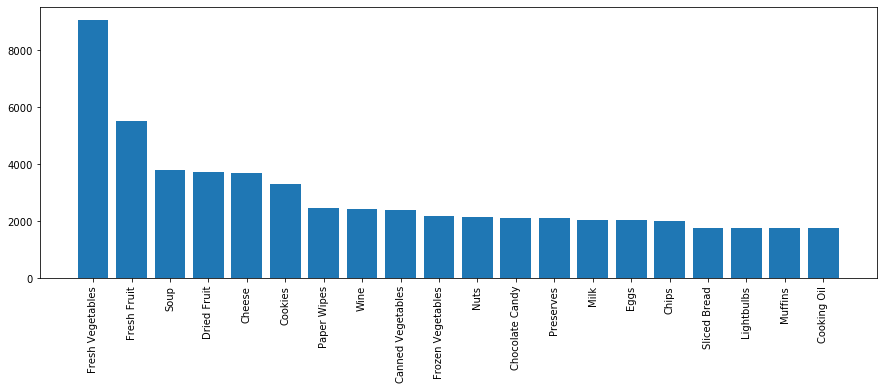

In [51]:
plt.figure(figsize=(15,5))
df_graph = df21_products_frequency.iloc[:20]
plt.bar(df_graph['product'],df_graph['total'])
plt.xticks(rotation=90)

#### 2.1.2. Compute Frequent Itemsets

In [52]:
X = 0.005
Y = 0.007

In [53]:
frequent_itemsets21_fpg  = fpgrowth(df21_te, min_support=X, use_colnames=True)
frequent_itemsets21_fpg = frequent_itemsets21_fpg.sort_values('support',ascending = False)
frequent_itemsets21_fpg['length'] = frequent_itemsets21_fpg['itemsets'].apply(lambda x: len(x))
frequent_itemsets21_fpg['num_transactions'] = [round(s*len(df2)) for s in frequent_itemsets21_fpg['support']]

In [54]:
frequent_itemsets21_fpg.query(f'length == 1 & support > {Y}')

,support,itemsets,length,num_transactions
2,0.290071,(Fresh Vegetables),1,9065
7,0.176282,(Fresh Fruit),1,5509
17,0.121340,(Soup),1,3792
3,0.119388,(Dried Fruit),1,3731
30,0.117980,(Cheese),1,3687
...,...,...,...,...
83,0.013120,(Sardines),1,410
86,0.012992,(Shrimp),1,406
101,0.012928,(Pots and Pans),1,404
16,0.012864,(Candles),1,402


In [55]:
frequent_itemsets21_fpg.query(f'length == 2 & support > {Y}')

,support,itemsets,length,num_transactions
126,0.051806,"(Fresh Vegetables, Fresh Fruit)",2,1619
164,0.036191,"(Fresh Vegetables, Soup)",2,1131
111,0.035679,"(Fresh Vegetables, Dried Fruit)",2,1115
206,0.031167,"(Fresh Vegetables, Cheese)",2,974
169,0.030015,"(Fresh Vegetables, Cookies)",2,938
...,...,...,...,...
326,0.007136,"(Dried Fruit, Waffles)",2,223
325,0.007136,"(Soup, Waffles)",2,223
251,0.007136,"(Chocolate Candy, Soup)",2,223
194,0.007040,"(Wine, Cheese)",2,220


In this case we are trying just one example, nothing much changes again.

#### 2.1.3. Generate Association Rules from Frequent Itemsets

In [56]:
C = 0.3 # Confidence
L = 1.1 # Lift

In [57]:
rules21 = association_rules(frequent_itemsets21_fpg, metric="confidence", min_threshold=0)
rules21['antecedent_len'] = rules21['antecedents'].apply(lambda x: len(x))

In [58]:
association_rules3 = generate_fi(rules21, 1, C, L)
association_rules3 = association_rules3.sort_values('support',ascending = False)
association_rules3

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
157,(Hard Candy),(Fresh Vegetables),0.028767,0.290071,0.009440,0.328142,1.131250,0.001095,1.056666,1
167,(Aspirin),(Fresh Vegetables),0.027647,0.290071,0.009088,0.328704,1.133185,0.001068,1.057550,1
169,(Sugar),(Fresh Vegetables),0.027423,0.290071,0.009024,0.329055,1.134395,0.001069,1.058103,1
244,"(Fresh Fruit, Soup)",(Fresh Vegetables),0.022399,0.290071,0.008064,0.360000,1.241077,0.001566,1.109265,2
491,(Conditioner),(Fresh Vegetables),0.013888,0.290071,0.005312,0.382488,1.318604,0.001283,1.149662,1
501,(Home Magazines),(Fresh Vegetables),0.014784,0.290071,0.005248,0.354978,1.223765,0.000960,1.100629,1
546,"(Fresh Fruit, Paper Wipes)",(Fresh Vegetables),0.015552,0.290071,0.005024,0.323045,1.113678,0.000513,1.048710,2


In [59]:
C = 0.35 # Confidence
L = 1.2  # Lift

In [60]:
association_rules4 = generate_fi(rules21, 1, C, L)
association_rules4 = association_rules4.sort_values('support',ascending = False)
association_rules4

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
244,"(Fresh Fruit, Soup)",(Fresh Vegetables),0.022399,0.290071,0.008064,0.360000,1.241077,0.001566,1.109265,2
491,(Conditioner),(Fresh Vegetables),0.013888,0.290071,0.005312,0.382488,1.318604,0.001283,1.149662,1
501,(Home Magazines),(Fresh Vegetables),0.014784,0.290071,0.005248,0.354978,1.223765,0.000960,1.100629,1


#### 2.1.4.  Deluxe/Gourmet Supermarkets versus All Stores


> There is some difference in the results from the association rules but this is most possibly caused by slight variations in the confidence and lift values which filter more cases in the first task.

> Overall the difference is not substantial and as has been said before, this dataset is very representative of the whole dataset in Task 1, which also happens due to the fact that these stores have half of all of the transactions.


### 2.2. Analyse Small Groceries [For groups of 2 and 3]

Here you should analyse **Small Groceries (STORE_ID = 2, 5, 14, 22)**.

#### 2.2.1.  Load/Preprocess the Dataset

In [61]:
len(df_itemset)

69549

In [62]:
df23 = pd.DataFrame(columns = df_itemset.columns) # new Itemset
for i in [2,5,14,22]:    
    df23 = pd.concat([df23,df_itemset[df_itemset['Column1'] == f'STORE_ID={i}']])
df23.shape

(2278, 11)

This time we will be dealing with a lot less transactions (2278)

In [63]:
#remove store column
df23 = df23.loc[:,'Column2':'Column11']
#clear quantities
df23 = df23.applymap(clear_quantities)

In [64]:
transactions_cleaned3 = remove_nan(df23.values)

#view just the first 5 transactions
transactions_cleaned3[:5]

[['Pasta', 'Soup'],
 ['Soup', 'Fresh Vegetables', 'Milk', 'Plastic Utensils'],
 ['Cheese', 'Deodorizers', 'Hard Candy', 'Jam'],
 ['Fresh Vegetables'],
 ['Cleaners', 'Cookies', 'Eggs', 'Preserves']]

In [65]:
te = TransactionEncoder().fit(transactions_cleaned3)
te_ary3 = te.transform(transactions_cleaned3)
df23_te = pd.DataFrame(te_ary3, columns=te.columns_)
df23_te.head()

,Acetominifen,Anchovies,Aspirin,Auto Magazines,Bagels,Batteries,Beer,Bologna,Candles,Canned Fruit,...,Sunglasses,TV Dinner,Tofu,Toilet Brushes,Tools,Toothbrushes,Tuna,Waffles,Wine,Yogurt
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Dataset is now ready to be introduced in the algorithms

#### 2.2.2. Compute Frequent Itemsets

In [66]:
X = 0.005
Y = 0.007

In [67]:
frequent_itemsets23_fpg  = fpgrowth(df23_te, min_support=X, use_colnames=True)
frequent_itemsets23_fpg = frequent_itemsets23_fpg.sort_values('support',ascending = False)
frequent_itemsets23_fpg['length'] = frequent_itemsets23_fpg['itemsets'].apply(lambda x: len(x))
frequent_itemsets23_fpg['num_transactions'] = [round(s*len(transactions_cleaned3)) for s in frequent_itemsets23_fpg['support']]

In [68]:
frequent_itemsets23_fpg.head()

,support,itemsets,length,num_transactions
2,0.277875,(Fresh Vegetables),1,633
29,0.176910,(Fresh Fruit),1,403
0,0.119842,(Soup),1,273
5,0.118525,(Cheese),1,270
32,0.107550,(Dried Fruit),1,245


In [69]:
frequent_itemsets23_fpg[(frequent_itemsets23_fpg['length']==1) & (frequent_itemsets23_fpg['support']> Y)]

,support,itemsets,length,num_transactions
2,0.277875,(Fresh Vegetables),1,633
29,0.176910,(Fresh Fruit),1,403
0,0.119842,(Soup),1,273
5,0.118525,(Cheese),1,270
32,0.107550,(Dried Fruit),1,245
...,...,...,...,...
93,0.010097,(Chocolate),1,23
96,0.009219,(Pot Scrubbers),1,21
98,0.009219,(Shrimp),1,21
54,0.008780,(Maps),1,20


In [70]:
frequent_itemsets23_fpg[(frequent_itemsets23_fpg['length']==2) & (frequent_itemsets23_fpg['support']> Y)]

,support,itemsets,length,num_transactions
220,0.044776,"(Fresh Vegetables, Fresh Fruit)",2,102
121,0.033363,"(Fresh Vegetables, Cheese)",2,76
231,0.033363,"(Fresh Vegetables, Dried Fruit)",2,76
102,0.030729,"(Fresh Vegetables, Soup)",2,70
130,0.024583,"(Fresh Vegetables, Cookies)",2,56
...,...,...,...,...
189,0.007024,"(Fresh Vegetables, French Fries)",2,16
344,0.007024,"(Cheese, Popsicles)",2,16
375,0.007024,"(Fresh Fruit, Sugar)",2,16
283,0.007024,"(Soda, Chocolate Candy)",2,16


In [71]:
frequent_itemsets23_fpg[(frequent_itemsets23_fpg['length']==3) & (frequent_itemsets23_fpg['support']> Y)]

,support,itemsets,length,num_transactions
245,0.007024,"(Fresh Vegetables, Fresh Fruit, Paper Wipes)",3,16


This time we are dealing with a smaller dataset which might deviate a lot more from the whole due to random chance. To have a support higher than 0.007 for example it is only needed to have around 17 transactions in these stores. The most bought products are still present and seen in this store with very similar values of support.

#### 2.2.3. Generate Association Rules from Frequent Itemsets

In [72]:
C = 0.3 # Confidence
L = 1.1 # Lift

In [73]:
rules23 = association_rules(frequent_itemsets23_fpg, metric="confidence", min_threshold=0)
rules23['antecedent_len'] = rules23['antecedents'].apply(lambda x: len(x))

In [74]:
association_rules_4 = generate_fi(rules23, 1, C, L)
association_rules_4 = association_rules_4.sort_values('support',ascending = False)
association_rules_4

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
5,(Dried Fruit),(Fresh Vegetables),0.107550,0.277875,0.033363,0.310204,1.116343,0.003477,1.046867,1
15,(Chocolate Candy),(Fresh Vegetables),0.071554,0.277875,0.022827,0.319018,1.148063,0.002944,1.060417,1
23,(Nuts),(Fresh Vegetables),0.067603,0.277875,0.021510,0.318182,1.145052,0.002725,1.059116,1
29,(Eggs),(Fresh Vegetables),0.063213,0.277875,0.020193,0.319444,1.149596,0.002628,1.061081,1
31,(Preserves),(Fresh Vegetables),0.064091,0.277875,0.019754,0.308219,1.109200,0.001945,1.043863,1
35,(Deli Meats),(Fresh Vegetables),0.056629,0.277875,0.018437,0.325581,1.171682,0.002702,1.070737,1
37,(Personal Hygiene),(Fresh Vegetables),0.052239,0.277875,0.018437,0.352941,1.270142,0.003921,1.116011,1
47,(Waffles),(Fresh Vegetables),0.053117,0.277875,0.016681,0.314050,1.130182,0.001921,1.052736,1
49,(Batteries),(Fresh Vegetables),0.049605,0.277875,0.016242,0.327434,1.178347,0.002458,1.073685,1
51,(Pizza),(Fresh Vegetables),0.051800,0.277875,0.016242,0.313559,1.128417,0.001848,1.051984,1


Now lets increase both the confidence and lift parameters

In [75]:
C = 0.4 # Confidence
L = 1.3 # Lift

In [76]:
association_rules_5 = generate_fi(rules23, 1, C, L)
association_rules_5 = association_rules_5.sort_values('support',ascending = False)
association_rules_5

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
383,(Ibuprofen),(Fresh Vegetables),0.013608,0.277875,0.006585,0.483871,1.741324,0.002803,1.399117,1
588,"(Chocolate Candy, Paper Wipes)",(Fresh Vegetables),0.009219,0.277875,0.005268,0.571429,2.056421,0.002706,1.684958,2


Interestingly enough, there is very high values of lift and confidence in this dataset, allowing us to identify products that have a high correlation and confidence for happening. 

For example we can know from this that it seems highly likely that buying Paper Wipes and cholocate Candy will mean that the person will buy Fresh Vegetables.

#### 2.2.4 Small Groceries versus All Stores

The results are not so different from the general again, but as said before, they are subjected to a random chance with smaller transactions, therefore to be more confident of the outcomes, it is suggested to have higher values of support for considering a product frequent.

An interesting case was the attained association rules which seem to be the most affected by the low number of transactions and since Fresh Vegetables are something that is usually bought, correlation and confidence values get to be higher in several cases.

### 2.3.  Deluxe/Gourmet Supermarkets versus Small Groceries  [For groups of 2 and 3]

In the first case we have dealt with a much bigger dataset, which had half of the whole transactions, while the second, only 3%. This means that the first one will of course be much more similar to the whole dataset. Since in task 2.1 we had many more transactions, it also allowed us to have more confident values for Condidence and Lift, as these won't be so subjected to random chance.

Still, in both Tasks we had very similar frequent itemsets with high support, showing us how patterns can be identified even in smaller examples.

**References**

[1] Jiawei Han, Micheline Kamber, and Jian Pei. 2011. Data Mining: Concepts and Techniques (3rd. ed.). Morgan Kaufmann Publishers Inc., San Francisco, CA, USA.